In [32]:
import math
import numpy as np
np.random.seed(0)
import sys
import os

np.set_printoptions(threshold=sys.maxsize)

current = os.path.dirname(os.path.realpath('__file__'))
parent = os.path.dirname(current)
parent = os.path.dirname(parent)
parent = os.path.dirname(parent)

sys.path.append(parent)

import benchmark
import tsp_qubo
import plotter
import annealing
        

In [33]:
class Parameters():
    '''Container for Qhea parameters'''
    def __init__(self, mutation_rate, optimiziation_rate, n_individuals, n_generations, segment_size, selection_pressure, bias):
        self.mutation_rate = mutation_rate
        self.optimiziation_rate = optimiziation_rate
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.segment_size = segment_size
        self.selection_pressure = selection_pressure
        self.bias = bias

In [34]:
class Data():
    '''Container to collect data from the algorithm'''
    fitness = 0
    value = 1
    def __init__(self, individual):
        self.evolution = np.array([individual], dtype=object)
        self.all_time_fittest = individual.copy()

    def add_individual(self, individual):
        self.evolution = np.vstack([self.evolution, individual])
        if self.all_time_fittest[self.fitness] > individual[self.fitness]:
            self.all_time_fittest = individual.copy()

    def get_evolution(self):
        return self.evolution
    
    def get_fitness_evolution(self):
        return self.evolution[:, self.fitness]
    
    def get_individual_evolution(self):
        return self.evolution[:, self.value]
    
    def get_solution(self):
        return self.all_time_fittest

In [35]:
class Qhea():
    fitness = 0 # variable used to index individual for fitness
    value = 1 # variable used to index individual for value, eg. chromosome
    def __init__(self, qubo, parameters):
        '''
        :param qubo: qubo matrix  to optimize (minimize)
        :param parameters: Parameter oject with params to execute the algorithm
        '''
        self.qubo = qubo # save qubo
        self.qubo_T = qubo.T
        self.n_vars = len(qubo) # n_vars is the chromosome size, 2 ** n_vars is the solution space
        self.n_nodes = int(math.sqrt(self.n_vars))
        self.n_individuals = parameters.n_individuals # size of the population
        self.n_generations = parameters.n_generations # number of generations 
        self.mutation_rate = parameters.mutation_rate # mutation probabilty per gene
        self.segment_size = parameters.segment_size # setting the dimension of a cluster
        self.n_segments = int( len(self.qubo) / self.segment_size) # number of clusters
        self.optimization_rate = parameters.optimiziation_rate # probability of local_optimiztaion
        self.selection_pressure = parameters.selection_pressure
        self.bias = parameters.bias
        self.population, self.cluster_chromsomes, self.data, self.probabilities = self.init() # init data
        self.genomes = self.cluster_chromsomes
        self.crossover_sequence = np.zeros(self.n_vars)
        self.slicing_sequence = self.genomes[0]
        
    def init(self):
        population = np.array([[0, np.random.randint(0, 2, self.n_vars)] for j in range(self.n_individuals)],
                      dtype=object) # init population
        
        for ind in range(self.n_individuals):
            population[ind][self.fitness] = self.cost_function(population[ind][self.value]) # initial fitness to population
        
        population = population[population[:, self.fitness].argsort()] # sort ascending by fitness
        
        crossover_sequence = self.get_crossover_sequences() # calculate crossover sequence
        data = Data(population[0]) # init data object to collect data from algorithm

        probabilities = []

        for i in range(1, self.n_individuals+1):
            p = (1 / self.n_individuals) * (self.selection_pressure - (2 * self.selection_pressure - 2) * (
                (i - 1) / (self.n_individuals - 1)))
            probabilities.append(p)

        return population, crossover_sequence, data, probabilities
    
    def cost_function(self, val):
        return val @ self.qubo @ val # calculate fitness


    def derive_sub_qubo(self,slicing_equence, chromosome):
        decision_vars_index = np.where(slicing_equence == 1)
        freeze_vars_index = np.where(slicing_equence == 0)
        freeze_vars = chromosome[freeze_vars_index]
        sub_qubo = self.qubo[decision_vars_index]
        sub_qubo = sub_qubo.T[decision_vars_index]
        sub_qubo = sub_qubo.T

        frozen_rows = self.qubo_T[freeze_vars_index].T[decision_vars_index]
        frozen_cols = self.qubo.T[decision_vars_index].T[freeze_vars_index].T


        sum_frozen = frozen_rows + frozen_cols
        
        vals = sum_frozen @ freeze_vars 
        sub_qubo += np.diag(vals)
        return sub_qubo, decision_vars_index
    

    def local_optimization(self, chromosome):
        r = np.random.uniform(0,1)
        if r < self.optimization_rate:
            for i in range(self.n_segments):
                slicing_sequence = self.get_slicing_sequence(i)
                chromosome = self.optimize_sub_problem(slicing_sequence, chromosome)
        return chromosome

    def get_slicing_sequence(self, index):
        self.slicing_sequence = self.genomes[index]
        return self.slicing_sequence
    
    def optimize_sub_problem(self, sequence, chromosome):
        sub_qubo, decision_vars_index = self.derive_sub_qubo(sequence, chromosome)
        solution = annealing.d_wave.anneal(sub_qubo)[0].astype(int)
        
        chromosome[decision_vars_index] = solution
        return chromosome
    
    def uniform_crossover_sequence(self):
        probabilities = np.random.uniform(0.0, 1.0, self.n_vars)

        return probabilities > self.bias
    

    def optimize(self):

        for gen in range(self.n_generations): # evolution loop
            self.mutation_rate = 1 / (gen + 1)
            for ind in range(int(self.n_individuals / 2)):            
                # mutation sequence is an array of [0,1], with a probabilty of mutation_rate for each index to be 1
                mutation_sequence_1 = np.random.random(self.n_vars) < self.mutation_rate # mutation sequence 1
                mutation_sequence_2 = np.random.random(self.n_vars) < self.mutation_rate # mutation sequence 2

                # selecting parents probabilistic
                parents = np.array([[0, np.random.randint(0, 2, self.n_vars)] for j in range(2)],
                      dtype=object)
                
                r = np.random.uniform(0,1,1)

                index_1 = (np.cumsum(self.probabilities)>r).argmax()
                parents[0] = self.population[index_1]

                r = np.random.uniform(0,1,1)
         
                # select parent_2        
                index_2 = (np.cumsum(self.probabilities)>r).argmax()
                parents[1] = self.population[index_2]
                # mutation sequence is an array of [0,1], with a probabilty of mutation_rate for each index to be 1
                mutation_sequence_1 = np.random.random(self.n_vars) < self.mutation_rate # mutation sequence 1
                mutation_sequence_2 = np.random.random(self.n_vars) < self.mutation_rate # mutation sequence 2
                self.crossover_sequence = self.uniform_crossover_sequence()
                # crossover with selected parents (first child), then mutation
                offspring_1_chromosome = np.logical_xor(
                np.add(
                    np.logical_and(parents[0][self.value], self.crossover_sequence), # getting the genes from first parent (where crossover is 1)
                    np.logical_and(parents[1][self.value], np.logical_xor(self.crossover_sequence, np.ones(self.n_vars))) # getting the genes from second parent (where crossover is 0)
                ),mutation_sequence_1)

                self.crossover_sequence = self.uniform_crossover_sequence()
                # crossover with selected parents (second child), then mutation
                offspring_2_chromosome = np.logical_xor(
                np.add(
                    np.logical_and(parents[1][self.value], self.crossover_sequence), # getting the genes from second parent (where crossover is 1)
                    np.logical_and(parents[0][self.value], np.logical_xor(self.crossover_sequence, np.ones(self.n_vars)))  # getting the genes from first parent (where crossover is 0)
                ), mutation_sequence_2)
                # note how the order of parents changed for individual 2
                self.population = np.vstack([self.population, np.array([0, offspring_1_chromosome], dtype=object)], dtype=object)
                self.population = np.vstack([self.population, np.array([0, offspring_2_chromosome], dtype=object)], dtype=object)

                offspring_1_chromosome = self.local_optimization(offspring_1_chromosome)
                offspring_2_chromosome = self.local_optimization(offspring_2_chromosome)
                
                
            # apply fitness to every new individual
            for ind in range(self.n_individuals, len(self.population)):
                self.population[ind][self.fitness] = self.cost_function(self.population[ind][self.value])
            
            # sort ascending by fitness
            self.population = self.population[self.population[:, self.fitness].argsort()]
            self.population = self.population[:self.n_individuals]
            # add fittest individual to data set
            self.data.add_individual(self.population[0])
        
        # when done, return data set
        return self.data
    


    def get_crossover_sequences(self):
        segments = []
        for i in range(self.n_segments):
            segment = np.zeros(len(self.qubo))
            segment[i * self.segment_size : i * self.segment_size + self.segment_size] = 1
            segments.append(segment)

        segments = np.array(segments)
        return segments

In [36]:
tsp = benchmark.distances.get_tsp(benchmark.distances.get_tsp_names()[4]).distances
n_nodes = len(tsp)
penalty = 100
constraint_matrix = np.zeros((n_nodes ** 2, n_nodes ** 2))
constraint_matrix = tsp_qubo.generate.apply_penalties(constraint_matrix, penalty)

amp = np.zeros((n_nodes, n_nodes))
for i in range(len(amp)):
    amp[i][(i + 1) % n_nodes] = 1
objective = np.kron(amp, tsp)
qubo = objective + constraint_matrix


1


-9124.0
2
-9252.0
3
-9124.0
4
-9183.0
5
-9172.0
[-9124.0, -9252.0, -9124.0, -9183.0, -9172.0]


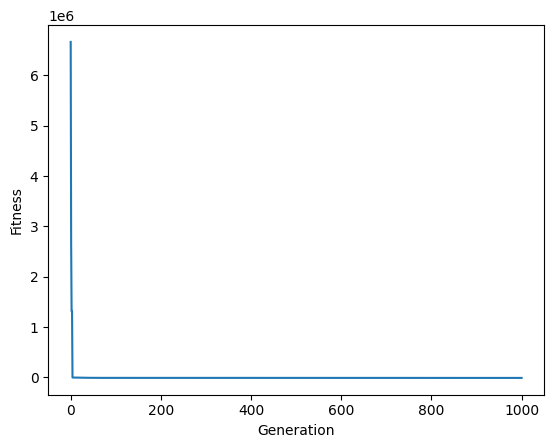

In [38]:
parameters = Parameters(
    mutation_rate=0.05,
    optimiziation_rate=0.005,
    n_individuals=100,
    n_generations=1000,
    segment_size=100,
    selection_pressure=2,
    bias = 0.5
)

evolutions = np.array([0 for i in range(parameters.n_generations+1)], dtype=object)
histogramm = []
for i in range(5):
    print(i+1)
    solver = Qhea(qubo=qubo,parameters=parameters)
    result = solver.optimize()
    evolution = result.get_fitness_evolution()
    evolutions = np.add(evolutions, evolution)
    histogramm.append(result.all_time_fittest[0])
    print(result.all_time_fittest[0])

print(repr(histogramm))
evolutions = evolutions / 5
plotter.plot_evolution(evolutions, "local_optimization_segments_ordered_0.5%", 3)


## Experiment Description
The Algorithm was tested with a medium mutation rate of 5% probability. 

## Result
<img src="files/local_optimization_cluster_large.png">